In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
import math
import time
import functionToOptimise as fun

In [2]:
class myCallback:
    def __init__(self):
        self.mxEvals = []
    def evaluate(self, x, *args):
        self.mxEvals.append(x)

In [ ]:
def simulatedAnnealing(objFun, minMax, xStart, initTemp, finalTemp, coolFactor, searchRadius, maxIterPerTemp, *args):
    # objFun : the function to optimize
    # minMax : 1 to minimize, -1 to maximize
    # xStart: starting point of the search
    # initTemp: initial Temperature
    # finalTemp: finalTemperature
    # coolFactor: parameters <1
    #             At each step temperature change, new temp = current temp * coolFactor
    # searchRadius: the radius of the ball inside which we look for a solution. 
    #               When current temperature < 1, the new search radius = current search radius * coolFactor
    # maxIterTemp: the maximum number of iterations we perform once we found a new optimum at a given temperature
    #              This defines the equilibrium condition at a given temperature, ie we've iterated maxIterPerTemp 
    #              without finding a better solution
    
    # Note on implementation:
    # When the current temperature falls below 1, the search radius gets multiplied by the coolFactor
    # This allows for intensification when we're near the end of the algorithm
    
    # Please note this is a custom implementation of simulated annealing. It was implemented so as to 
    # allow better identification of which parameter to change when convergence isn't obtained.
    # To achieve this, the algorithm "normalizes" delta (the change in energy) using the average delta 
    # at the equilibrium position for a given temperature. This avoids having to adjust for initial temperatures
    # and final temperatures so that the order of magnitude depends on the energy delta. We get a better control
    # of the barrier level for diversification.
    
    funDim = args[0]
    curTemp = initTemp
    xBest = np.copy(xStart)
    fxBest = objFun(xBest, funDim) * minMax
    
    # to store all evaluated points and associated function values
    xIter = []
    fxIter = []
    
    # to store best x and f(xBest) for a given temperature
    bestxTemp = []
    bestfxTemp = []
    probs = []
        
    iterCount = 0
    while curTemp > finalTemp:
        #restarting from our equilibrium point (ie best value so far)
        x = np.copy(xBest)
        fx = fxBest
        iterCount = 0
        deltaAvg = 0
        probVec = []
        
        #we reach equilibrium at this temperature if we iterated maxIterPerTemp times without improving the best solution
        while iterCount < maxIterPerTemp:
            xTest = x + np.random.uniform(-searchRadius, searchRadius, x.shape[0])
            fxTest = objFun(xTest, funDim) * minMax
            delta = fxTest - fx
            deltaAvg = (iterCount*deltaAvg+abs(delta))/(iterCount+1)
            
            if delta >0:
                lim_prob = np.exp(-(delta/deltaAvg)/curTemp)
                probVec.append(lim_prob)

            if delta < 0 or np.random.random() < np.exp(-(delta/deltaAvg)/curTemp):
                x = np.copy(xTest)
                fx = fxTest
            iterCount+=1
            
            if fxTest < fxBest:
                #we improved the best solution, reset iterCount to 0 and store new best solution 
                iterCount = 0
                deltaAvg = 0
                xBest = np.copy(xTest)
                fxBest = fxTest

            xIter.append(x)
            fxIter.append(objFun(x, funDim))
        bestxTemp.append(xBest)
        bestfxTemp.append(objFun(xBest, funDim))
        probs.append(np.mean(probVec))
        if curTemp <1:
            # below 1 degree, decrease the search radius to increase intensification
            searchRadius *= coolFactor
        curTemp *= coolFactor

    return bestxTemp, bestfxTemp, xIter, fxIter, probs

In [ ]:
f = fun.shiftedRastrigin
low = -5
high = 5
my_dim = 50

#np.random.seed(1235)
x_init = np.random.uniform(low=low, high=high, size=(my_dim))
cback = myCallback()
startTime = time.time()

initTemp = 100
finalTemp = 0.01
coolFactor = 0.8
searchRadius = 0.1
maxIterTemp = 100
minMax = 1  #minimize = 1, maximize = -1

bestxTemp, bestfxTemp, xEvals, fxEvals, probs = simulatedAnnealing(f, minMax, x_init, initTemp, finalTemp, coolFactor, searchRadius, maxIterTemp, my_dim)

#print('starting point: {}'.format(x_init))
#print('solution: {}'.format(bestxTemp[-1]))
#print('function value: {}'.format(bestfxTemp[-1]))


#sol50 = minimize(f, x_init, method='CG', args=(my_dim,), callback = cback.evaluate, 
#                options = {'disp':False, 'maxiter':51, 'gtol':1e-6, 'norm': np.inf, 'eps':1e-2})
runTime = time.time() - startTime

#print('message: {}'.format(sol50.message))
print('function value: {:.2f}'.format(bestfxTemp[-1]))
print('true minimum: {}'.format(fun.fbias[3]))
#print('number of iterations: {}'.format(sol50.nit))
print('Computational time: {:.2f} s'.format(runTime))

In [ ]:
fig = plt.figure()
tempZoom = 0
g1 = fig.add_subplot(1, 3, 1)
plt.plot([i for i in range(tempZoom, len(bestfxTemp))], np.array(bestfxTemp[tempZoom:]))
g1.set_xlabel('temperature iteration')
g1.set_ylabel('Best Function Value at current t ')
g1.title.set_text('Best Value found across temperature iterations')

g2 = fig.add_subplot(1, 3, 2)
plt.plot([i for i in range(len(xEvals))], np.array(fxEvals))
g2.set_xlabel('evaluation number')
g2.set_ylabel('function value')
g2.title.set_text('function value as a function of iterations')

startPos = 3000
g3 = fig.add_subplot(1, 3, 3)
plt.plot([i for i in range(tempZoom, len(probs))], np.array(probs[tempZoom:]))

fig.set_figwidth(20)

# Dimension 50

In [8]:
f = fun.shiftedAckley
low = -32
high = 32
my_dim = 50

np.random.seed(1236)
x_init = np.random.uniform(low=low, high=high, size=(my_dim))
cback = myCallback()
startTime = time.time()
sol50 = minimize(f, x_init, method='CG', args=(my_dim,), callback = cback.evaluate, 
                options = {'disp':False, 'maxiter':51, 'gtol':1e-20, 'norm': np.inf, 'eps':1e-2})
runTime = time.time() - startTime
print('message: {}'.format(sol50.message))
print('function value: {:.2f}'.format(sol50.fun))
print('true minimum: {}'.format(fun.fbias[5]))
print('number of iterations: {}'.format(sol50.nit))
print('Computational time: {:.2f} s'.format(runTime))

message: Desired error not necessarily achieved due to precision loss.
function value: -120.18
true minimum: -140.0
number of iterations: 7
Computational time: 0.06 s


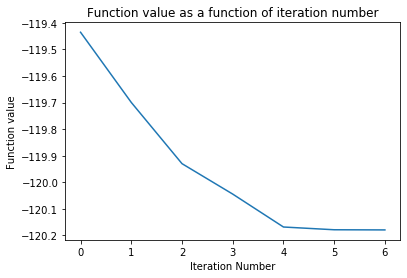

In [9]:
plt.plot([i for i in range(len(cback.mxEvals))], [f(cback.mxEvals[i], my_dim) for i in range(len(cback.mxEvals))])
plt.xlabel('Iteration Number')
plt.ylabel('Function value')
plt.title('Function value as a function of iteration number')
plt.savefig('convergenceCurve_dim_' + str(my_dim))

# Dimension 500

In [10]:
f = fun.shiftedAckley
low = -32
high = 32
my_dim = 500

np.random.seed(1236)
x_init = np.random.uniform(low=low, high=high, size=(my_dim))
cback = myCallback()
startTime = time.time()
sol500 = minimize(f, x_init, method='CG', args=(my_dim,), callback = cback.evaluate, 
                options = {'disp':False, 'maxiter':51, 'gtol':1e-6, 'norm': np.inf, 'eps':1e-2})
runTime = time.time() - startTime
print('message: {}'.format(sol500.message))
print('function value: {:.2f}'.format(sol500.fun))
print('true minimum: {}'.format(fun.fbias[5]))
print('number of iterations: {}'.format(sol500.nit))
print('Computational time: {:.2f} s'.format(runTime))

message: Desired error not necessarily achieved due to precision loss.
function value: -120.13
true minimum: -140.0
number of iterations: 10
Computational time: 1.18 s


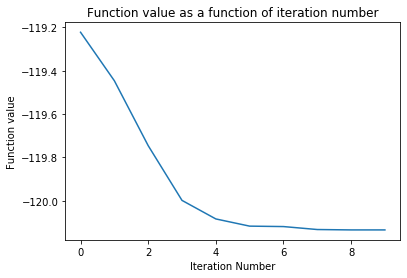

In [11]:
plt.plot([i for i in range(len(cback.mxEvals))], [f(cback.mxEvals[i], my_dim) for i in range(len(cback.mxEvals))])
plt.xlabel('Iteration Number')
plt.ylabel('Function value')
plt.title('Function value as a function of iteration number')
plt.savefig('convergenceCurve_dim_' + str(my_dim))